In [32]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
# import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
# from datasets import Dataset
# from peft import LoraConfig, PeftConfig
# from trl import SFTTrainer
# from trl import setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,AutoModelForSeq2SeqLM,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df= pd.read_csv('labeled_data.csv')

In [3]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df['label'] = np.where((df['class'] == 0) | (df['class'] == 1), 0, 1)

In [5]:
df['label'].value_counts()

0    20620
1     4163
Name: label, dtype: int64

In [21]:
desired_ratio = 0.6 / 0.4  # 60-40 ratio

# Number of data points in label 1
num_label_1 = df['label'].value_counts()[1]

# Calculate the desired number of data points for label 0
num_label_0_desired = int(num_label_1 * desired_ratio)

# Randomly sample from label 0 to achieve the desired number
df_label_0 = df[df['label'] == 0].sample(n=num_label_0_desired, random_state=1)

# Combine the sampled label 0 data with all the label 1 data
balanced_df = pd.concat([df_label_0, df[df['label'] == 1]])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=1)

# Check the value counts to verify the balance
balanced_df['label'].value_counts()

0    6244
1    4163
Name: label, dtype: int64

In [22]:
balanced_df=balanced_df.drop('Unnamed: 0',axis=1)

In [23]:
balanced_df.count()

count                 10407
hate_speech           10407
offensive_language    10407
neither               10407
class                 10407
tweet                 10407
label                 10407
dtype: int64

In [24]:
balanced_df=balanced_df.drop(['hate_speech','offensive_language','neither'],axis=1)

In [25]:
def convert_to_prompt(text):
    return f'[INST] In this task, you will be performing a classification exercise aimed at identifying whether the given text contains hate speech or not. Consider the text: {text} </prompt>'

# Create a new column 'prompt' by combining the 'text' column with the label in prompt format
balanced_df['prompt'] = balanced_df['tweet'].apply(convert_to_prompt)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train_data, test_data = train_test_split(balanced_df, test_size=0.2, random_state=42)

In [28]:

train_data.to_csv('balanced_hatespeech_dataset.csv', index=False)
test_data.to_csv('balanced_hatespeech_dataset1.csv', index=False)

In [29]:
b_df=pd.read_csv('balanced_hatespeech_dataset1.csv')

In [30]:
b_df.head()

,count,class,tweet,label,prompt
0,3,2,Flabby bird sounds Turrible. Lol. I'll just st...,1,"[INST] In this task, you will be performing a ..."
1,3,2,@AjKFAN Big congrats to all! I expect him to b...,1,"[INST] In this task, you will be performing a ..."
2,3,2,"This Isn't Murica, Charlie Brown. #rejectedpea...",1,"[INST] In this task, you will be performing a ..."
3,3,1,"If not for GZ, #Trayvon would be alive right t...",0,"[INST] In this task, you will be performing a ..."
4,3,0,RT @Wayne__Da__Boss: I hate a bitch dat act li...,0,"[INST] In this task, you will be performing a ..."


In [2]:
# !pip install autotrain-advanced

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 90.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.1/282.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/1

In [ ]:
!pip install huggingface_hub

In [47]:
!autotrain setup

INFO     | 2024-05-11 10:57:26 | autotrain.cli.run_setup:run:43 - Installing latest xformers
INFO     | 2024-05-11 10:57:26 | autotrain.cli.run_setup:run:45 - Successfully installed latest xformers


In [50]:
!autotrain llm --help

usage: autotrain <command> [<args>] llm [-h] [--train] [--deploy]
                                        [--inference] [--username USERNAME]
                                        [--backend {spaces-a10g-large,spaces-a10g-small,spaces-a100-large,spaces-t4-medium,spaces-t4-small,spaces-cpu-upgrade,spaces-cpu-basic,spaces-l4x1,spaces-l4x4,spaces-a10g-largex2,spaces-a10g-largex4,dgx-a100,dgx-2a100,dgx-4a100,dgx-8a100,ep-aws-useast1-s,ep-aws-useast1-m,ep-aws-useast1-l,ep-aws-useast1-xl,ep-aws-useast1-2xl,ep-aws-useast1-4xl,ep-aws-useast1-8xl,nvcf-l40sx1,nvcf-h100x1,nvcf-h100x2,nvcf-h100x4,nvcf-h100x8,local-ui,local,local-cli}]
                                        [--token TOKEN] [--push-to-hub]
                                        --model MODEL --project-name
                                        PROJECT_NAME [--data-path DATA_PATH]
                                        [--train-split TRAIN_SPLIT]
                                        [--valid-split VALID_SPLIT]
             

In [11]:
base_model1= "NousResearch/Llama-2-7b-chat-hf"

In [52]:
!autotrain llm --train --project-name hatespeech --model NousResearch/Llama-2-7b-chat-hf --data-path 'balanced-data' --mixed_precision fp16 --text-column 'prompt' --use-peft --quantization int4 --lr 2e-4 --train-batch-size 10 --epochs 1 --trainer sft --model-max-length 512 


INFO     | 2024-05-11 11:06:12 | autotrain.cli.run_llm:run:344 - Running LLM
WARNING  | 2024-05-11 11:06:12 | autotrain.trainers.common:__init__:180 - Parameters supplied but not used: func, inference, backend, version, config, train, deploy
INFO     | 2024-05-11 11:06:12 | autotrain.backends.local:create:8 - Starting local training...
INFO     | 2024-05-11 11:06:12 | autotrain.commands:launch_command:349 - ['accelerate', 'launch', '--multi_gpu', '--num_machines', '1', '--num_processes', '2', '--mixed_precision', 'fp16', '-m', 'autotrain.trainers.clm', '--training_config', 'hatespeech/training_params.json']
INFO     | 2024-05-11 11:06:12 | autotrain.commands:launch_command:350 - {'model': 'NousResearch/Llama-2-7b-chat-hf', 'project_name': 'hatespeech', 'data_path': '/kaggle/input/balanced-data', 'train_split': 'train', 'valid_split': None, 'add_eos_token': False, 'block_size': -1, 'model_max_length': 512, 'padding': None, 'trainer': 'sft', 'use_flash_attention_2': False, 'log': 'none',

In [ ]:
print(balanced_df['prompt'])

15468    <s>[INST] In this task, you will be performing...

11188    <s>[INST] In this task, you will be performing...

8569     <s>[INST] In this task, you will be performing...

19760    <s>[INST] In this task, you will be performing...

20382    <s>[INST] In this task, you will be performing...

                               ...                        

24701    <s>[INST] In this task, you will be performing...

9008     <s>[INST] In this task, you will be performing...

1739     <s>[INST] In this task, you will be performing...

18205    <s>[INST] In this task, you will be performing...

18508    <s>[INST] In this task, you will be performing...

Name: prompt, Length: 10407, dtype: object


In [33]:
tokenizer = AutoTokenizer.from_pretrained('hatespeech')
model = AutoModelForSeq2SeqLM.from_pretrained('hatespeech')


In [36]:
test_data = pd.read_csv('balanced_hatespeech_dataset1.csv')

In [39]:
def generate_predictions(model, tokenizer, input_texts, max_length=128):
    device = next(model.parameters()).device
    inputs = tokenizer.batch_encode_plus(input_texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=4, early_stopping=True)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)


In [51]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Calculate predictions
predictions = []
for index, row in tqdm(test_data[:100].iterrows(), total=100):
    prediction = generate_predictions(model, tokenizer, [row['prompt']])
    predictions.append(prediction[0])


100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


Accuracy: 0.97
F1 Score: 0.9672453324598755
Precision: 0.9703296703296703
Recall: 0.9644097222222222
Classification Report:
                 precision    recall  f1-score   support

    Hate Speech       0.97      0.98      0.98        64
Not Hate Speech       0.97      0.94      0.96        36

       accuracy                           0.97       100
      macro avg       0.97      0.96      0.97       100
   weighted avg       0.97      0.97      0.97       100

Confusion Matrix:
[[63  1]
 [ 2 34]]


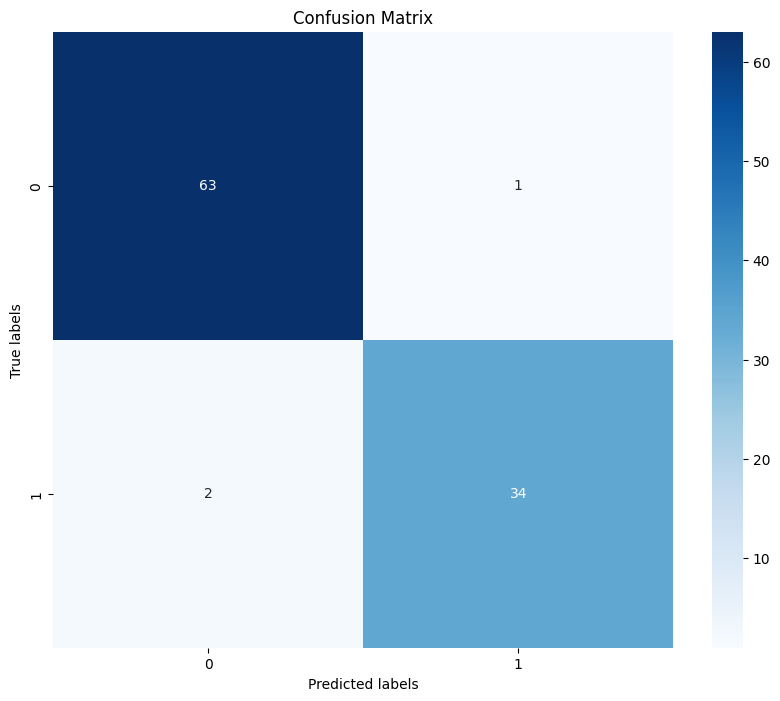

In [54]:
df = test_data[:100].copy()
df['predicted'] = predictions


# Convert numeric labels to strings
df['label'] = df['label'].map({0: 'Hate Speech', 1: 'Not Hate Speech'})

# Calculate metrics
accuracy = accuracy_score(df['label'], df['predicted'])
f1 = f1_score(df['label'], df['predicted'], average='macro')
precision = precision_score(df['label'], df['predicted'], average='macro')
recall = recall_score(df['label'], df['predicted'], average='macro')

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Generate classification report
print("Classification Report:")
print(classification_report(df['label'], df['predicted']))

# Generate confusion matrix
conf_matrix = confusion_matrix(df['label'], df['predicted'])
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
